In [95]:
import IPython 
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
import wave
%matplotlib inline
import time
from datetime import timedelta as td

In [96]:
#wav_loc = r'Audiofile.wav'
wav_loc = r'recorded_audio2.wav'
rate, data = wavfile.read(wav_loc,mmap=False)

In [97]:
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real



# def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1): 
#     freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate)) 
#     f = np.zeros(samples)
#     f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
#     return fftnoise(f)

# IPython.display.Audio(data=data, rate=rate)


In [98]:
def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1): 
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate)) 
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [99]:
IPython.display.Audio(data=data, rate=rate)

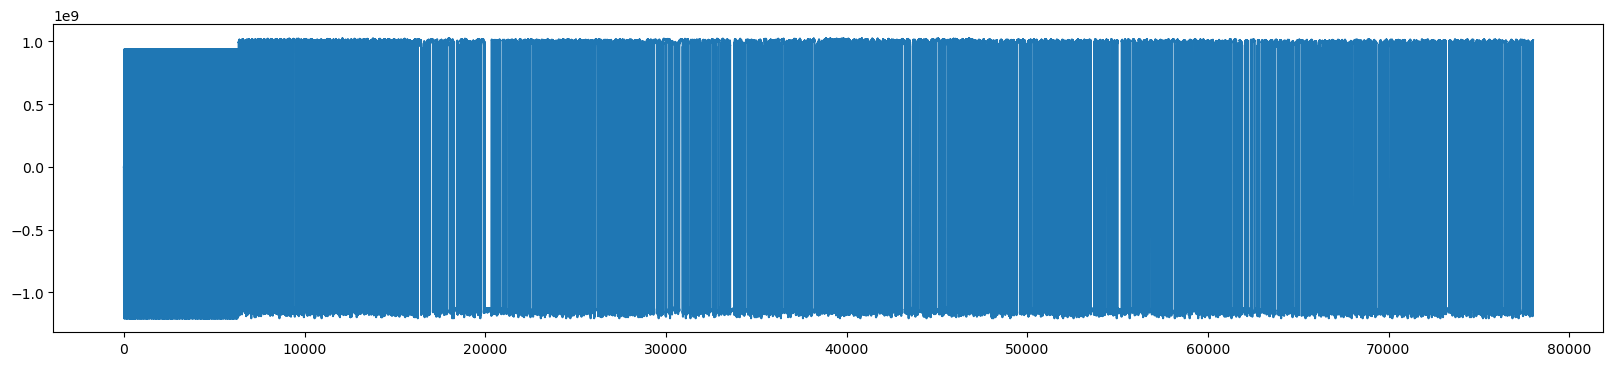

In [100]:
#ploting the given data 
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)

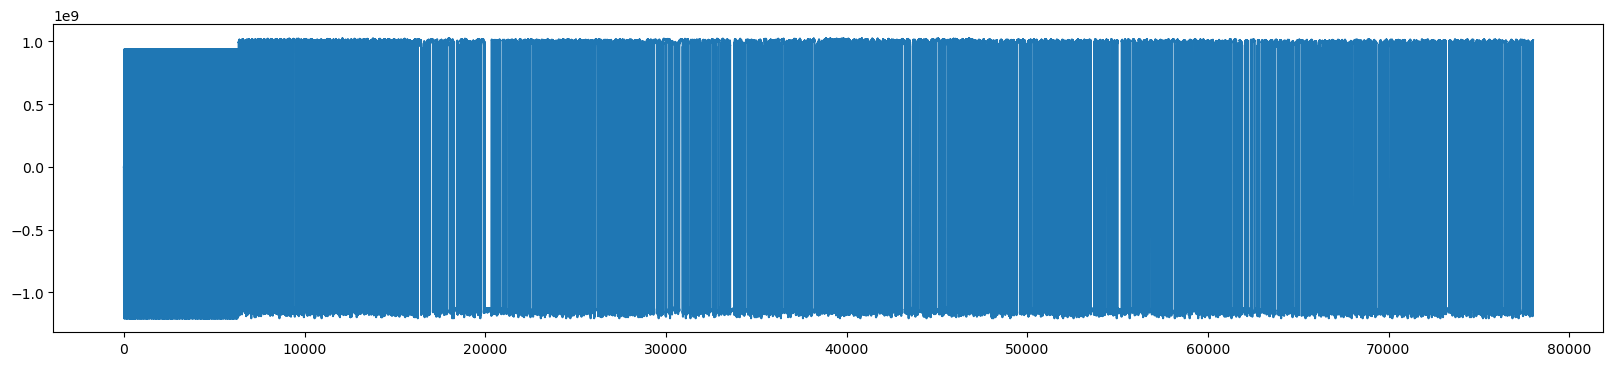

In [101]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=4000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_band_limited)
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)
#IPython.display.Audio(data=noise, rate=rate)

In [102]:
import time
from datetime import timedelta as td

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    
def _istft(y, hop_length, win_length):
    #return librosa.istft(y=y, hop_length=hop_length, win_length=win_length)
    #return librosa.istft(y,hop_length, win_length)
    return librosa.istft(y)

def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)
def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(                
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )

    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(            
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise") 
                                                                       
                                                                       
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")  
    ax[0].set_title("Threshold for mask")    
                                             
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask") 
                                                
    plt.show()


def removeNoise(   # to average the signal (voltage) of the positive-slope portion (rise) of a triangle wave to try to remove as much noise as possible. 

    audio_clip,    # these clips are the parameters used on which we would do the respective operations 
    noise_clip,
    n_grad_freq=2,    # how many frequency channels to smooth over with the mask.
    n_grad_time=4,    # how many time channels to smooth over with the mask.
    n_fft=2048,       # number audio of frames between STFT columns.
    win_length=2048,  # Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
    hop_length=512,   # number audio of frames between STFT columns.
    n_std_thresh=1.5, # how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
    prop_decrease=1.0, #To what extent should you decrease noise (1 = all, 0 = none)
    verbose=False,     # flag allows you to write regular expressions that look presentable
    visual=False,      #Whether to plot the steps of the algorithm
):
    if verbose:
        start = time.time() 
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  

     
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    #calculate the threshold for each frequency/time bin
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    #Convolve the mask with a soothing layer
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()

        # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))        
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal


    

STFT on noise: 0:00:00.008975
STFT on signal: 0:00:00.009974
[-59.81875766 -59.81871826 -59.81858843 ...   4.09806665   5.41640884
   8.19963983] 154.3977998676273
Masking: 0:00:00.006982
Mask convolution: 0:00:00.015958
Mask application: 0:00:00.018982
Signal recovery: 0:00:00.331113


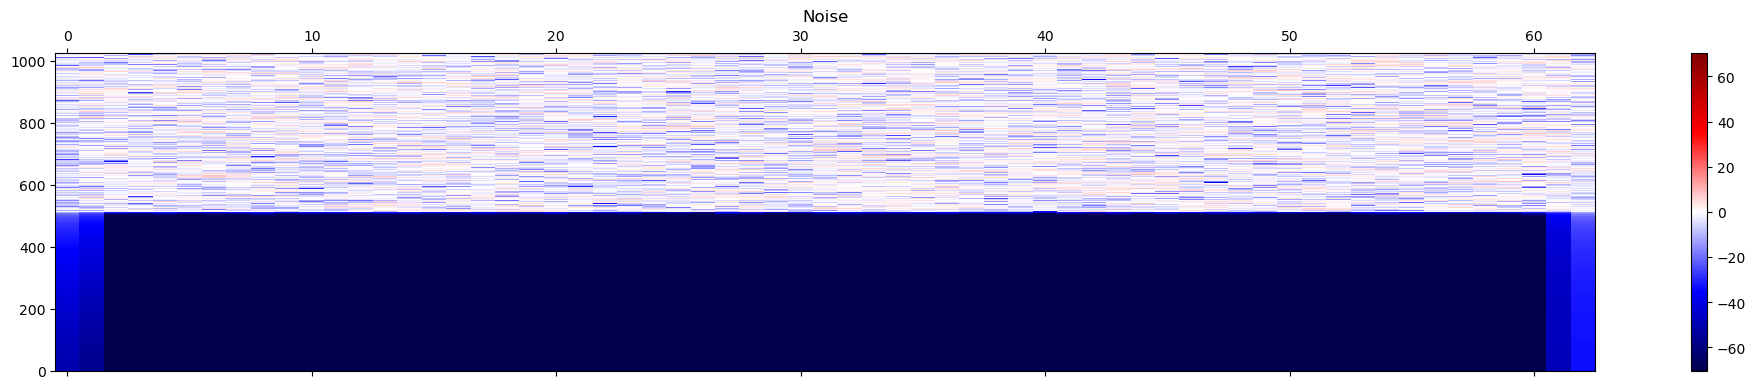

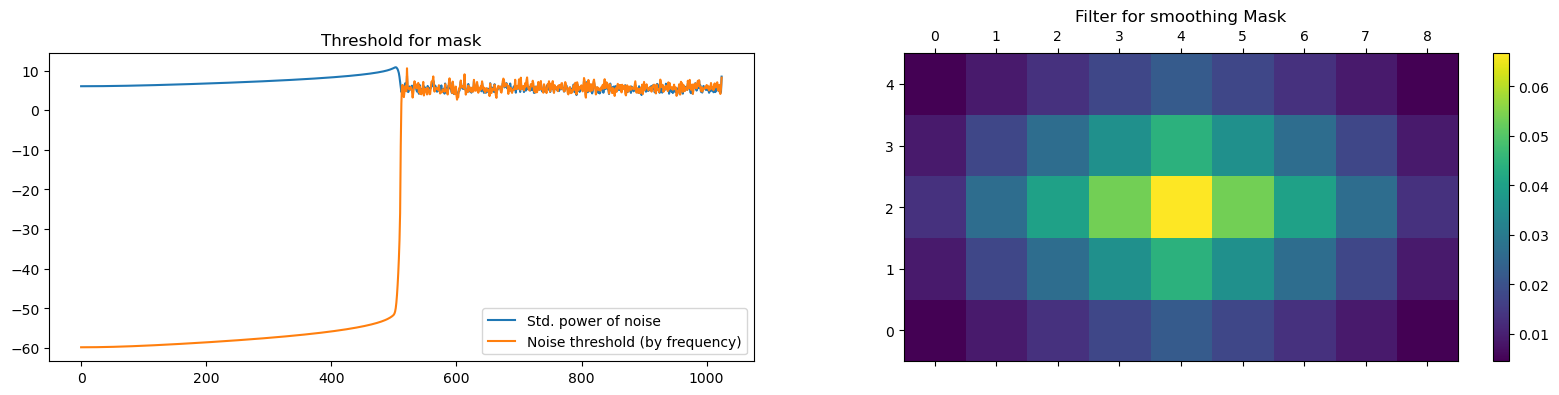

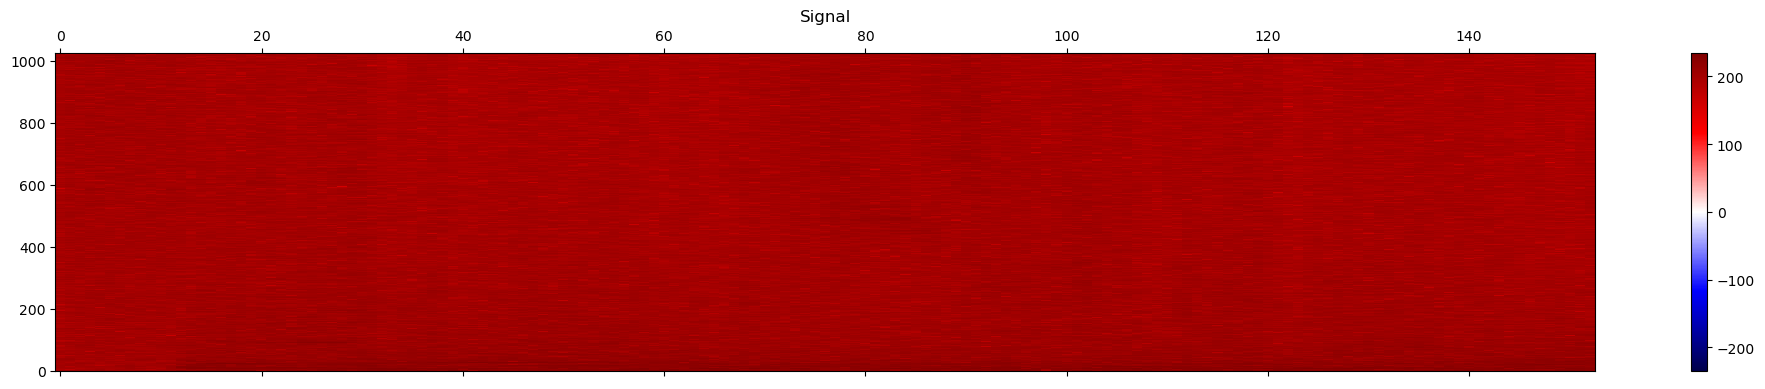

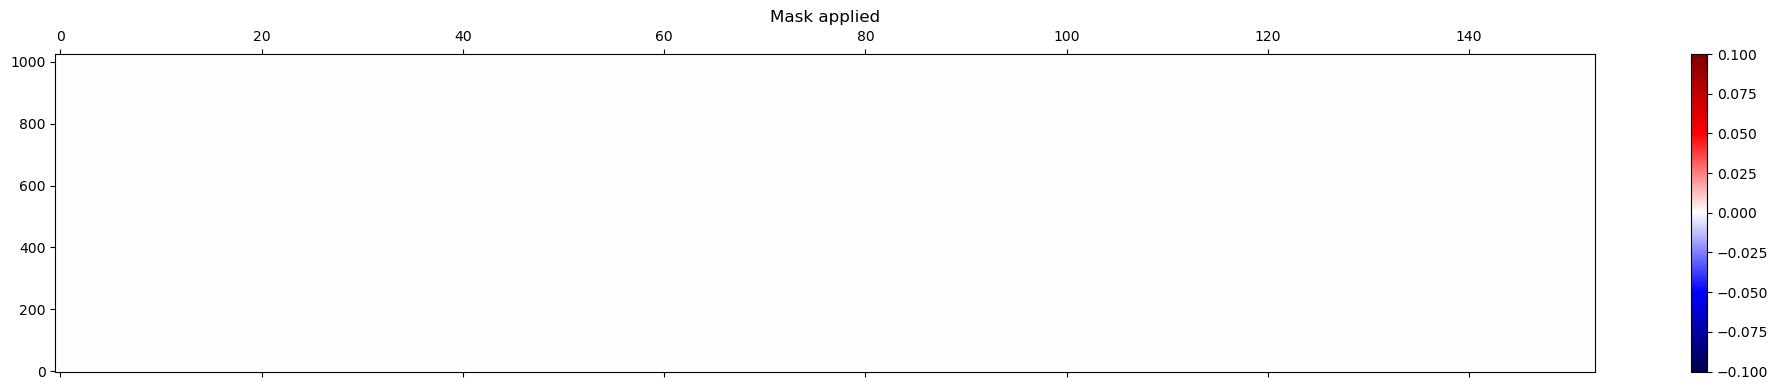

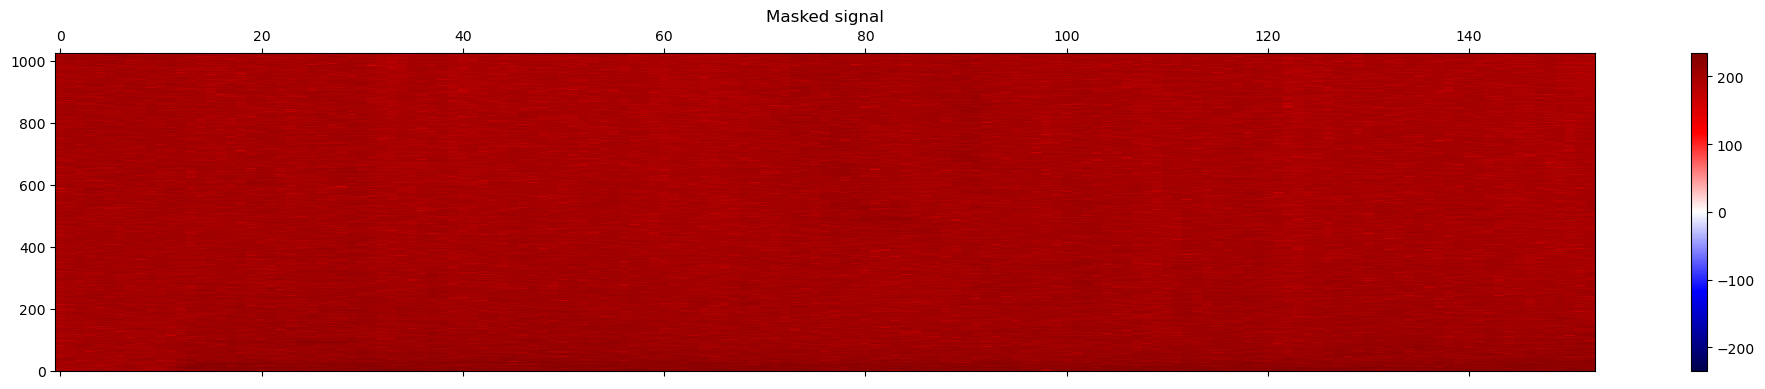

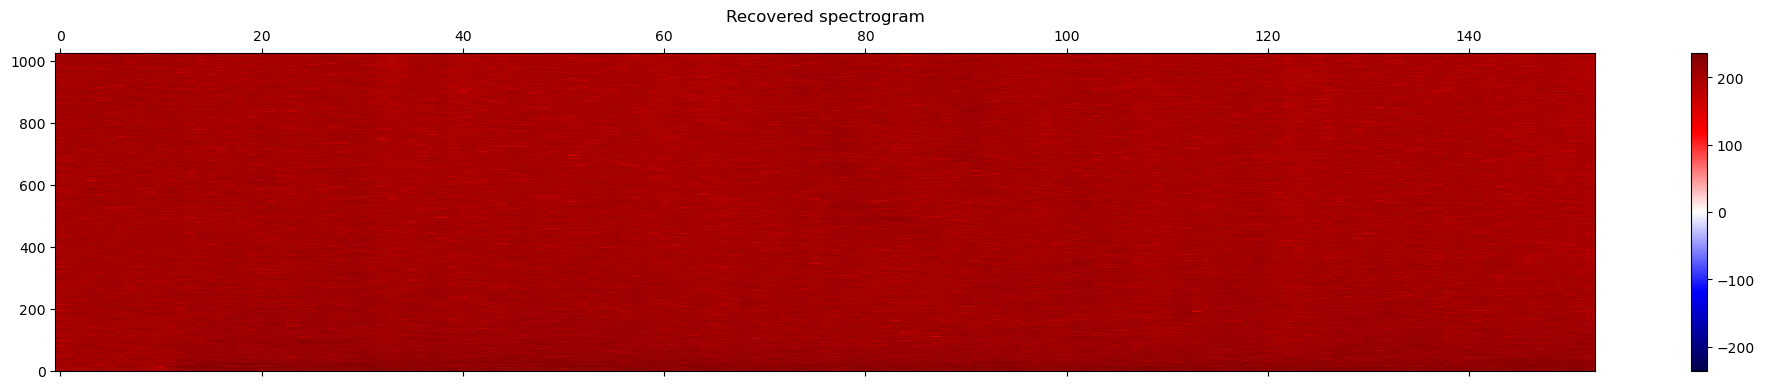

In [103]:
output = removeNoise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip, verbose=True,visual=True)